# Analysis of the historical price of a troy ounce of silver adjusted for inflation

## Setup

In [1]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from statsmodels.tsa.seasonal import STL

In [2]:
# Get silver price and US CPI dfs and set date and year_month as index
df_ag = pd.read_csv("../data/AG.csv", index_col="date", parse_dates=True)
df_cpi = pd.read_csv("../data/US_CPI_M.csv", index_col="year_month", parse_dates=True)

In [3]:
# Append the CPI estimate for April of 2024 to the CPI df
df_cpi.loc[pd.to_datetime("2024-04")] = {"rate": 3.4}

In [4]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

## Adjustment of silver price for inflation (using 2023 prices)

In [5]:
# Make CPI rates decimal
df_cpi["rate"] = df_cpi["rate"] / 100

In [6]:
# Get cumulative product of rates until 2023 (which is the base year)
all_months = []
for month in range(1, 12 + 1):
    # Cumulative product of year over year CPI rate for each month number
    cumulative_product = np.cumprod((1 + df_cpi[:f"2023-{month:02}"]["rate"])[::-12])
    # Shift the cumulative product to align with the prior year
    cumulative_product = cumulative_product.shift(1).fillna(1)
    all_months.append(cumulative_product)

In [7]:
# Add cumulative CPI rates to the df
df_cpi["cumulative_rate"] = pd.concat(all_months)

In [8]:
# Get 2024 months cumulative rate by just inverting respective rate
df_cpi.loc[df_cpi.index.year == 2024, "cumulative_rate"] = 1 / (1 + df_cpi["rate"])

In [9]:
# Add the cumulative CPI rates to the silver price df (May values will have the same rate as April)
df_cpi_reindexed = df_cpi.reindex(df_ag.index, method="ffill")
df_ag["cpi_cumulative_rate"] = df_cpi_reindexed["cumulative_rate"]

In [10]:
# Adjust all prices to 2023 dollars
df_ag["real_price"] = df_ag["price"] * df_ag["cpi_cumulative_rate"]

## Price of silver adjusted for inflation across time

In [11]:
# Get 1-year moving average
df_ag["real_price_1y_ma"] = df_ag["real_price"].rolling(window=252).mean()

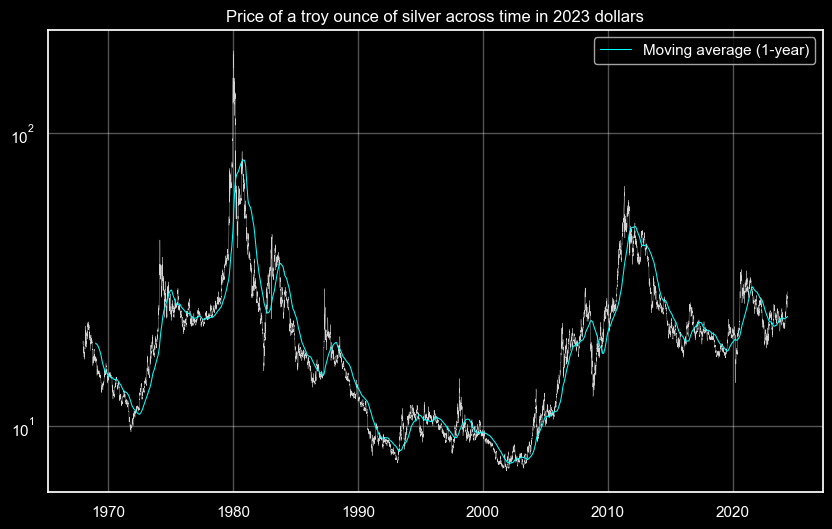

In [12]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_ag, x=df_ag.index, y="real_price", color="lightgrey", linewidth=0.25)
sns.lineplot(data=df_ag, x=df_ag.index, y="real_price_1y_ma", label="Moving average (1-year)", color="aqua", linewidth=0.75)

# Compress the y axis to see early price fluctuations
plt.yscale("log")

plt.title("Price of a troy ounce of silver across time in 2023 dollars")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("3.2_AG_real_price")

**Comparison of real price with nominal price**

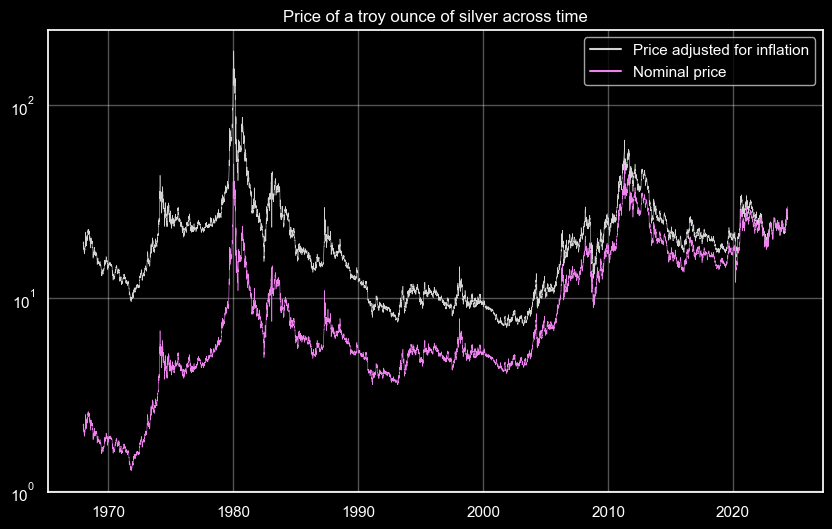

In [13]:
plt.figure(figsize=(10, 6))

real_color = "lightgrey"
nominal_color = "violet"

sns.lineplot(data=df_ag, x=df_ag.index, y="real_price", color=real_color, linewidth=0.4)
sns.lineplot(data=df_ag, x=df_ag.index, y="price", color=nominal_color, linewidth=0.4)

# Compress the y axis to see early price fluctuations
plt.yscale("log")

plt.title("Price of a troy ounce of silver across time")
plt.xlabel("")
plt.ylabel("")

# Manually create legend handles with a larger linewidth just to be able to see it
legend_handles = [Line2D([0], [0], color=real_color, lw=1.5, label="Price adjusted for inflation"),
                  Line2D([0], [0], color=nominal_color, lw=1.5, label="Nominal price")]
plt.legend(handles=legend_handles)

save_chart_as_png("3.2_AG_real_and_nominal_price")

In [14]:
# All-time high
ath_date = df_ag["real_price"].idxmax()
df_ag.loc[[ath_date], ["real_price"]]

,real_price
date,
1980-01-18,190.153683


In [15]:
# All-time low
atl_date = df_ag["real_price"].idxmin()
df_ag.loc[[atl_date], ["real_price"]]

,real_price
date,
2001-11-21,7.035864


In [16]:
# Peaks
peaks, _ = signal.find_peaks(df_ag["real_price"], distance=800)
df_ag.iloc[peaks].nlargest(10, "real_price").sort_values("date")[["real_price"]].T

date,1968-06-12,1974-02-26,1980-01-18,1983-05-31,1987-04-27,2008-02-27,2011-04-28,2014-07-10,2020-09-01,2024-04-12
real_price,22.650167,43.092781,190.153683,41.526212,29.407638,27.470144,65.688679,27.585966,34.157389,28.0706


In [17]:
# Valleys
valleys, _ = signal.find_peaks(-df_ag["real_price"], distance=1000)
df_ag.iloc[valleys].nsmallest(10, "real_price").sort_values("date")[["real_price"]].T

date,1971-11-02,1976-01-21,1982-06-07,1986-05-20,1993-03-09,1997-07-17,2001-11-21,2005-11-07,2016-01-28,2020-03-19
real_price,9.549361,20.608293,18.621085,13.553061,7.482842,8.045101,7.035864,11.630955,17.148393,14.038476


In [18]:
# Real price appreciation since first entry
first_entry_price = df_ag.iloc[0]["real_price"]
last_entry_price = df_ag.iloc[-1]["real_price"]
(last_entry_price - first_entry_price) / first_entry_price

0.5056359265824882

**Key takeaways:**
- The real price of silver shows significant fluctuations without substantial long-term increases.
- Silver's price has not kept pace with inflation as effectively as gold.
- Unlike gold, silver's all-time high remains unchanged, while the all-time low shifted to 2001.
- Similar to gold, silver experienced a major valley between the 1980s and 2010s, a smaller valley in the 2010s, and an even smaller valley after 2020. However, the peaks have become progressively smaller.
- Since the initial point, the real price of silver has only appreciated by approximately 50%.

### Real price change year-over-year

In [19]:
# Get YoY real returns
# Get yearly silver real price df with first and last prices
df_ag_yearly = df_ag.groupby(df_ag.index.year)["real_price"].agg(
    first_price="first",
    last_price="last"
)
# Get YoY return
df_ag_yearly["real_price_change"] = (df_ag_yearly["last_price"] - df_ag_yearly["first_price"]) / df_ag_yearly["first_price"]

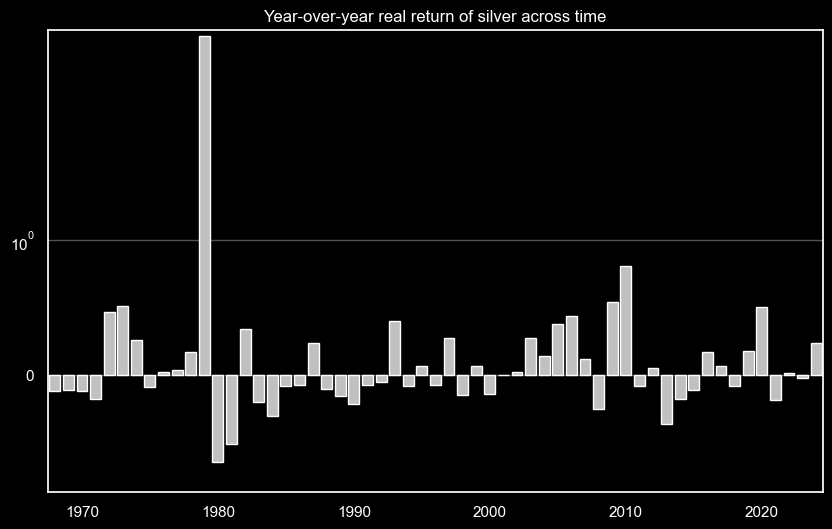

In [20]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df_ag_yearly, x=df_ag_yearly.index, y="real_price_change", color="silver")

# Compress the y axis to see smaller bars
plt.yscale("symlog")

plt.title("Year-over-year real return of silver across time")
plt.xlabel("")
plt.ylabel("")

# Show only beginning of decade
ax = plt.gca()
for index, label in enumerate(ax.get_xticklabels()):
    if index % 10 - 2 != 0:
        label.set_visible(False)

save_chart_as_png("3.2_AG_YoY_real_return")

In [21]:
# Average YoY real return
df_ag_yearly["real_price_change"].mean().round(4)

0.1026

In [22]:
# Average YoY real return since 1980
df_ag_yearly.loc[1980:]["real_price_change"].mean().round(4)

0.0259

In [23]:
# Average YoY real return since 2000
df_ag_yearly.loc[2000:]["real_price_change"].mean().round(4)

0.1001

In [24]:
# Median YoY real return
df_ag_yearly["real_price_change"].median().round(4)

0.0005

In [25]:
# Standard deviation YoY real return
df_ag_yearly["real_price_change"].std().round(4)

0.5694

In [26]:
# Cumulative product YoY real return
(1 + df_ag_yearly["real_price_change"]).cumprod().iloc[-1].round(4) - 1

3.7977999999999996

In [27]:
# Get average, median, standard deviation and cumulative product YoY return per decade
df_ag_yearly["decade"] = (df_ag_yearly.index // 10) * 10
df_ag_yearly.groupby("decade").agg(
    avg_yoy_price_change=("real_price_change", lambda x: x.mean().round(4)),
    median_yoy_price_change=("real_price_change", lambda x: x.median().round(4)),
    std_yoy_price_change=("real_price_change", lambda x: x.std().round(4)),
    cumprod_yoy_price_change=("real_price_change", lambda x: (1 + x).cumprod().iloc[-1].round(4) - 1),
    dod_price_change=("decade", lambda x: (df_ag_yearly.loc[x.index, "last_price"].iloc[-1] - df_ag_yearly.loc[x.index, "first_price"].iloc[0]) / df_ag_yearly.loc[x.index, "first_price"].iloc[0])
).T

decade,1960,1970,1980,1990,2000,2010,2020
avg_yoy_price_change,-0.116000,0.491100,-0.150100,0.016600,0.150000,0.045600,0.10900
median_yoy_price_change,-0.116000,0.104100,-0.128000,-0.062700,0.128600,-0.013700,0.01600
std_yoy_price_change,0.002200,1.197600,0.297000,0.191000,0.255500,0.313800,0.26520
cumprod_yoy_price_change,-0.218500,10.028800,-0.896300,0.017600,2.204300,0.096200,0.50160
dod_price_change,-0.235619,8.039422,-0.917391,-0.205972,1.567757,-0.091362,0.38082


**Key takeaways:**
- The average year-over-year real return of silver is 10.3%, which is notably high, although the median is 0%.
- When considering data since the 1980s, the average real return of silver drops to 2.6%.
- Since the 2000s, the real return averages 10%, aligning with gold's performance.

### STL decomposition (trend, seasonality, and residuals)

In [28]:
stl = STL(df_ag["real_price"], period=252).fit()

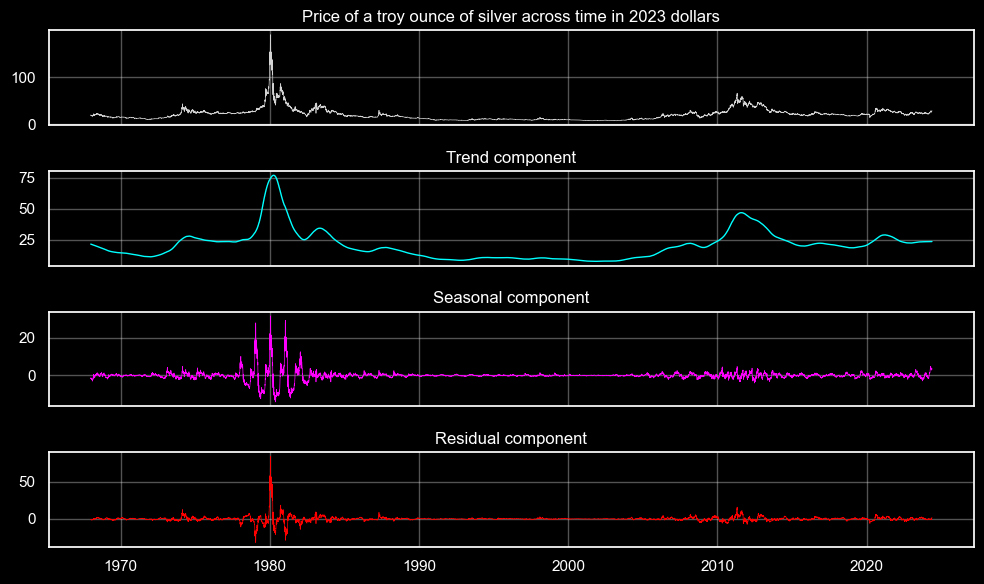

In [29]:
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].plot(df_ag.index, df_ag["real_price"], label="Original", color="lightgrey", linewidth=0.5)
axes[0].set_title("Price of a troy ounce of silver across time in 2023 dollars")

axes[1].plot(df_ag.index, stl.trend, label="Trend", color="aqua", linewidth=1)
axes[1].set_title("Trend component")

axes[2].plot(df_ag.index, stl.seasonal, label="Seasonal", color="fuchsia", linewidth=0.5)
axes[2].set_title("Seasonal component")

axes[3].plot(df_ag.index, stl.resid, label="Residual", color="red", linewidth=0.5)
axes[3].set_title("Residual component")

plt.tight_layout()

#### Trend analysis

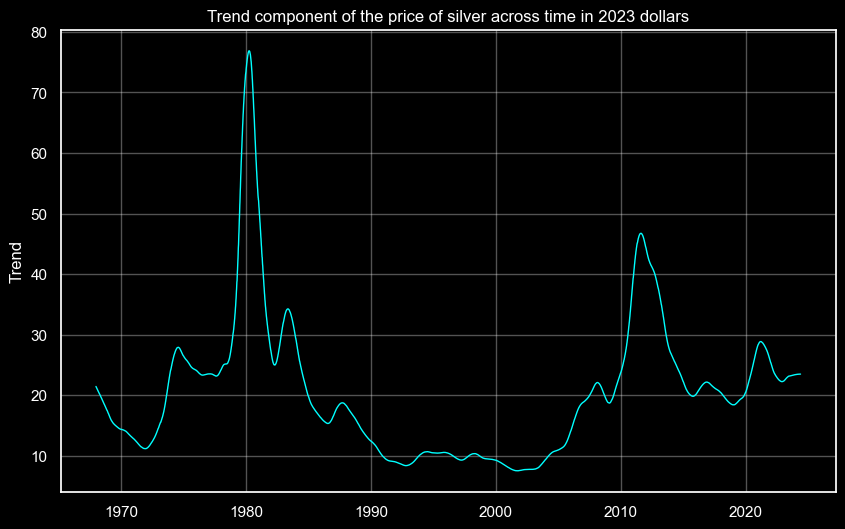

In [30]:
plt.figure(figsize=(10, 6))

plt.plot(stl.trend, color="aqua", linewidth=1)

plt.title("Trend component of the price of silver across time in 2023 dollars")
plt.xlabel("")
plt.ylabel("Trend")

save_chart_as_png("3.2_AG_real_trend")

In [31]:
# Top 5 peaks
peaks, _ = signal.find_peaks(stl.trend, distance=500)
top_peaks = stl.trend.iloc[peaks].nlargest(5)
pd.DataFrame({"value": top_peaks}).T

date,1980-04-03,2011-08-09,1983-05-12,2021-03-11,1974-07-30
value,76.875258,46.74785,34.261604,28.870834,27.928545


**Similar to gold, silver exhibits a clearer valley in its trend, but its second peak is significantly smaller than the first, and the third is smaller than the second.**

#### Seasonality analysis

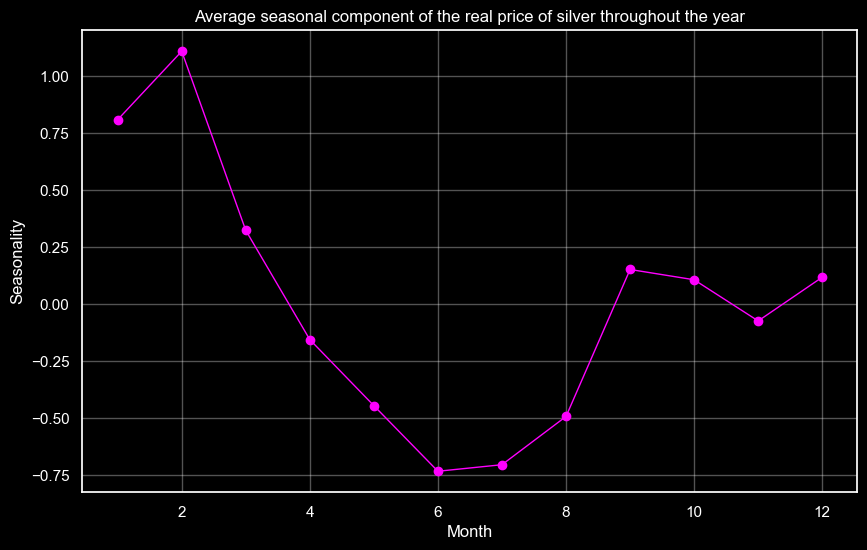

In [32]:
seasonal = stl.seasonal
monthly_avgs = seasonal.groupby(seasonal.index.month).mean()

plt.figure(figsize=(10, 6))

plt.plot(monthly_avgs.index, monthly_avgs.values, marker='o', color="fuchsia", linewidth=1)

plt.title("Average seasonal component of the real price of silver throughout the year")
plt.xlabel("Month")
plt.ylabel("Seasonality")

save_chart_as_png("3.2_AG_real_seasonal")

**Adjusting for inflation, silver's average seasonality shows significant changes. Notable decline in April and a rise in the last quarter.**

*No need to check anything related to volatility or short-term price analysis.*